In [623]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, LSTM

# Modelado y Forecasting
# ==============================================================================
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler


import skforecast
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from skforecast.utils import save_forecaster
from skforecast.utils import load_forecaster
import shap

In [886]:
# Cargar los datos históricos de ventas desde un archivo 
path='E:/Job/ventas_ANDI_Complete_Hist_Just_MonturaCD.xlsx'
datos=pd.read_excel(path, sheet_name='Sheet1',usecols=['fecha','Tot_Bill'])
datos.dropna(subset=['Tot_Bill'],inplace=True)
filter2 = data['marca'] == "CD" #monturas 
datos['fecha'] = datos['fecha'].dt.year.astype('str') + '-' + datos['fecha'].dt.month.astype('str') + '-01'
datos.where(filter2, inplace=True)
datos = datos.groupby(['fecha']).Tot_Bill.sum().reset_index()
print(f'Número de filas con missing values: {datos.isnull().any(axis=1).mean()}')
datos['fecha'] = pd.to_datetime(datos['fecha'])
datos = datos.set_index(datos['fecha'])
datos = datos.asfreq(freq='MS')
datos = datos.sort_index()
#datos

Número de filas con missing values: 0.0


In [887]:
datos = datos.drop('fecha',axis=1)
datos.head(3)

,Tot_Bill
fecha,
2019-11-01,42550100.0
2019-12-01,52421800.0
2020-01-01,23383900.0


In [888]:
groups_means = datos['Tot_Bill'].mean()
datos['Tot_Bill'] = datos['Tot_Bill'].fillna(groups_means)

In [889]:
# Verificar que un índice temporal está completo
# ==============================================================================
(datos.index == pd.date_range(
                    start = datos.index.min(),
                    end   = datos.index.max(),
                    freq  = datos.index.freq)
).all()

True

In [890]:
# Separación datos train-test
# ==============================================================================
steps = 12
steps2 = 15
datos_train = datos[:-steps]
#datos_test  = datos[-steps:]
datos_test  = datos[-steps2:]
print(f"Fechas train : {datos_train.index.min()} --- {datos_train.index.max()}  (n={len(datos_train)})")
print(f"Fechas test  : {datos_test.index.min()} --- {datos_test.index.max()}  (n={len(datos_test)})")

Fechas train : 2019-11-01 00:00:00 --- 2022-12-01 00:00:00  (n=38)
Fechas test  : 2022-10-01 00:00:00 --- 2023-12-01 00:00:00  (n=15)


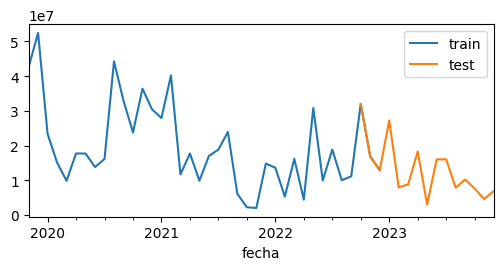

In [891]:
fig, ax = plt.subplots(figsize=(6, 2.5))
datos_train['Tot_Bill'].plot(ax=ax, label='train')
datos_test['Tot_Bill'].plot(ax=ax, label='test')
ax.legend();

In [892]:
datos_train.head(3)

,Tot_Bill
fecha,
2019-11-01,42550100.0
2019-12-01,52421800.0
2020-01-01,23383900.0


In [893]:
# Crear y entrenar forecaster
#el modelo, utiliza como predictores los 12 datos anteriores.
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags = 12
             )
forecaster.fit(y=datos_train["Tot_Bill"])
forecaster

ForecasterAutoreg 
Regressor: RandomForestRegressor(random_state=123) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12] 
Transformer for y: None 
Transformer for exog: None 
Window size: 12 
Weight function included: False 
Differentiation order: None 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2019-11-01 00:00:00'), Timestamp('2022-12-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: MS 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
fit_kwargs: {} 
Creation date: 2024-05-28 16:48:16 
Last fit date: 2024-05-28 16:48:

In [894]:
#Una vez entrenado el modelo, se predicen los datos de test (12 meses a futuro).
steps = 15
predicciones = forecaster.predict(steps=steps)
predicciones.head(5)

2023-01-01    1.602378e+07
2023-02-01    1.427609e+07
2023-03-01    1.771774e+07
2023-04-01    1.569818e+07
2023-05-01    1.119410e+07
Freq: MS, Name: pred, dtype: float64

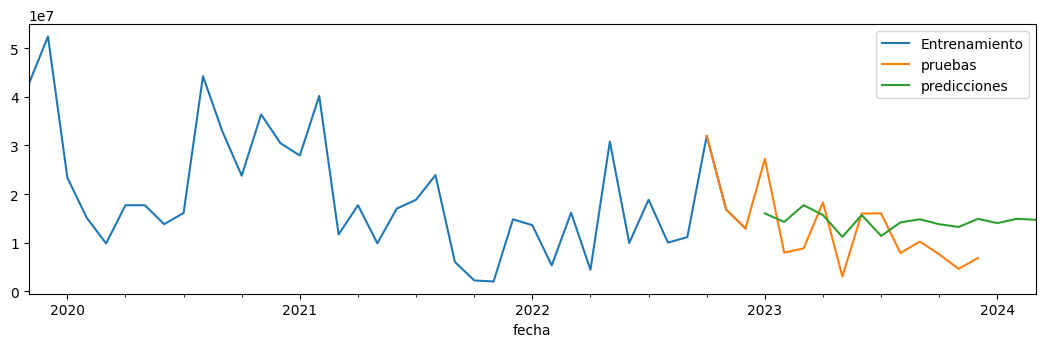

In [895]:
# Gráfico de predicciones vs valores reales
# ==============================================================================
fig, ax = plt.subplots(figsize=(13, 3.5))
datos_train['Tot_Bill'].plot(ax=ax, label='Entrenamiento')
datos_test['Tot_Bill'].plot(ax=ax, label='pruebas')
predicciones.plot(ax=ax, label='predicciones')
ax.legend();

In [896]:
#Se cuantifica el error que comete el modelo en sus predicciones. En este caso, se emplea 
#como métrica el mean squared error (mse).

error_mse = mean_squared_error(
                y_true = datos_test['Tot_Bill'],
                y_pred = predicciones
            )
print(f"Error de test (mse): {error_mse}")


Error de test (mse): 60882353810386.23


In [852]:
print(int(len(datos_train)*0.7))

22


In [908]:
steps = 15
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags      = 6 # Este valor será remplazado en el grid search
             )

# Valores candidatos de lags
lags_grid = [3, 21]

# Valores candidatos de hiperparámetros del regresor
param_grid = {
      'n_estimators': [100, 250],
      'max_depth': [3, 5, 10]
}

resultados_grid = grid_search_forecaster(
                        forecaster         = forecaster,
                        y                  = datos_train['Tot_Bill'],
                        param_grid         = param_grid,
                        lags_grid          = lags_grid,
                        steps              = steps,
                        refit              = False,
                        metric             = 'mean_squared_error',
                        initial_train_size = int(len(datos_train)*0.7),
                        fixed_train_size   = False,
                        return_best        = True,
                        n_jobs             = 'auto',
                        verbose            = False
                  )

Number of models compared: 12.


lags grid: 100%|██████████| 2/2 [00:01<00:00,  1.21it/s]  

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3] 
  Parameters: {'max_depth': 10, 'n_estimators': 250}
  Backtesting metric: 74819473119930.31



In [909]:
resultados_grid

,lags,lags_label,params,mean_squared_error,max_depth,n_estimators
5,"[1, 2, 3]","[1, 2, 3]","{'max_depth': 10, 'n_estimators': 250}",7.481947e+13,10,250
6,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 3, 'n_estimators': 100}",7.558928e+13,3,100
8,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 5, 'n_estimators': 100}",7.558928e+13,5,100
10,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 10, 'n_estimators': 100}",7.558928e+13,10,100
7,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 3, 'n_estimators': 250}",7.804150e+13,3,250
9,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 5, 'n_estimators': 250}",7.804150e+13,5,250
11,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 10, 'n_estimators': 250}",7.804150e+13,10,250
1,"[1, 2, 3]","[1, 2, 3]","{'max_depth': 3, 'n_estimators': 250}",8.031870e+13,3,250
2,"[1, 2, 3]","[1, 2, 3]","{'max_depth': 5, 'n_estimators': 100}",8.151920e+13,5,100
0,"[1, 2, 3]","[1, 2, 3]","{'max_depth': 3, 'n_estimators': 100}",8.866373e+13,3,100


In [910]:
# Crear y entrenar forecaster con mejores hiperparámetros obtenido en la simulacion anterior
# ==============================================================================
regressor = RandomForestRegressor(max_depth=10, n_estimators=250, random_state=123)
forecaster = ForecasterAutoreg(
                regressor = regressor,
                lags      = 3
             )
forecaster.fit(y=datos_train['Tot_Bill'])

In [911]:
predicciones = forecaster.predict(steps=steps)

In [912]:
predicciones

2023-01-01    1.733366e+07
2023-02-01    2.033169e+07
2023-03-01    1.854641e+07
2023-04-01    1.325432e+07
2023-05-01    1.457947e+07
2023-06-01    2.347502e+07
2023-07-01    1.907133e+07
2023-08-01    1.402472e+07
2023-09-01    1.373528e+07
2023-10-01    2.845369e+07
2023-11-01    2.485348e+07
2023-12-01    1.518829e+07
2024-01-01    1.363297e+07
2024-02-01    1.730928e+07
2024-03-01    1.851106e+07
Freq: MS, Name: pred, dtype: float64

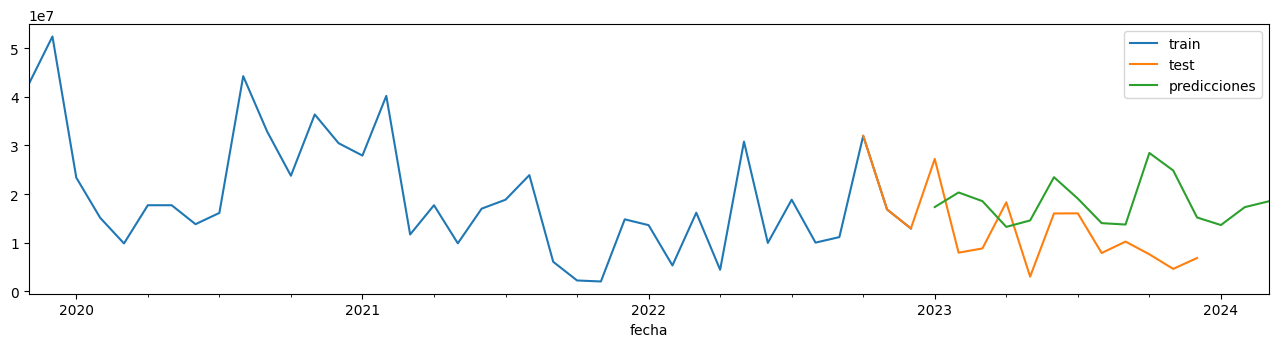

In [913]:
fig, ax = plt.subplots(figsize=(16, 3.5))
datos_train['Tot_Bill'].plot(ax=ax, label='train')
datos_test['Tot_Bill'].plot(ax=ax, label='test')
predicciones.plot(ax=ax, label='predicciones')
ax.legend();

In [914]:
error_mse = mean_squared_error(
                y_true = datos_test['Tot_Bill'],
                y_pred = predicciones
            )
print(f"Error de test (mse) {error_mse}")

Error de test (mse) 109301112911130.7


In [916]:
# Backtesting
#Backtesting sin reentrenamiento
#Con esta estrategia, el modelo se entrena una única vez con un conjunto inicial y se realizan las predicciones de forma secuencial 
#sin actualizar el modelo y siguiendo el orden temporal de los datos. Esta estrategia tiene la ventaja de ser mucho más rápida puesto 
#que el modelo solo se entrena una vez. La desventaja es que el modelo no incorpora la última información disponible por lo que puede
#perder capacidad predictiva con el tiempo.
# ==============================================================================
steps = 12
n_backtesting = 12*3 # Se separan para el backtest los últimos 3 años
metrica, predicciones_backtest = backtesting_forecaster(
                                    forecaster         = forecaster,
                                    y                  = datos['Tot_Bill'],
                                    initial_train_size = len(datos) - n_backtesting,
                                    fixed_train_size   = False,
                                    steps              = steps,
                                    refit              = True,
                                    metric             = 'mean_squared_error',
                                    verbose            = True
                                 )
print(f"Error de backtest: {metrica}")

Information of backtesting process
----------------------------------
Number of observations used for initial training: 14
Number of observations used for backtesting: 36
    Number of folds: 3
    Number of steps per fold: 12
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2019-11-01 00:00:00 -- 2020-12-01 00:00:00  (n=14)
    Validation: 2021-01-01 00:00:00 -- 2021-12-01 00:00:00  (n=12)
Fold: 1
    Training:   2019-11-01 00:00:00 -- 2021-12-01 00:00:00  (n=26)
    Validation: 2022-01-01 00:00:00 -- 2022-12-01 00:00:00  (n=12)
Fold: 2
    Training:   2019-11-01 00:00:00 -- 2022-12-01 00:00:00  (n=38)
    Validation: 2023-01-01 00:00:00 -- 2023-12-01 00:00:00  (n=12)



100%|██████████| 3/3 [00:00<00:00, 348.13it/s]


Error de backtest: 173211206193493.0
